In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 63.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=728063 sha256=bd5da925b29522fc048d7a8a5be2ea728f8ab300f968e0a0ea0c89769676a7fb
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


<Axes: xlabel='Date'>

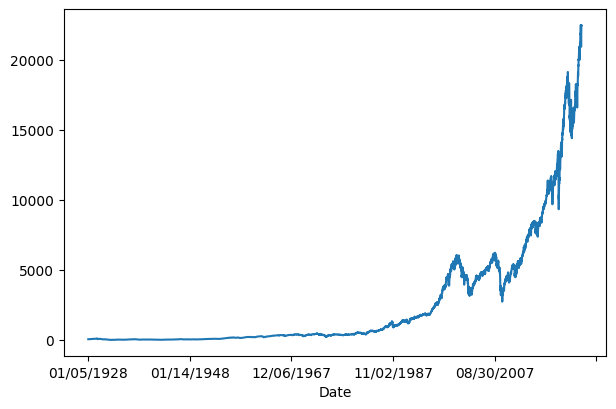

In [3]:
import yfinance as yf
SP500 = yf.Ticker("^GSPC")

# get historical market data
SP500 = SP500.history(period="max")

SP500 = SP500.Close
SP500 = SP500.rolling(4).sum()
SP500 = SP500.dropna()
SP500.index = SP500.index.strftime('%m/%d/%Y')

SP500.plot()

In [4]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(30, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [5]:
autoencoder.compile(optimizer='adam', loss='mae')

In [6]:
def normalize_window_roll(data, window_size):
    X = []
    Y = []
    for i in range(0,len(data) - window_size,5):
        x_window = data.iloc[i:i+window_size]

        # Normalize the x_window and y_window
        scaler = MinMaxScaler()
        x_window = scaler.fit_transform(np.array(x_window).reshape(-1, 1))

        X.append(x_window)
    X =np.squeeze(np.array(X), axis=2)

    return X

In [7]:
X= normalize_window_roll(SP500,30)

In [9]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_test = X[train_size:train_size+test_size]
X_val = X[train_size+test_size:train_size+test_size+val_size]

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=40,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])


Epoch 1/40
213/213 [==============================] - 1s 3ms/step - loss: 0.2244 - val_loss: 0.1689
Epoch 2/40
213/213 [==============================] - 0s 2ms/step - loss: 0.1462 - val_loss: 0.1132
Epoch 3/40
213/213 [==============================] - 0s 2ms/step - loss: 0.1059 - val_loss: 0.1006
Epoch 4/40
213/213 [==============================] - 0s 2ms/step - loss: 0.1003 - val_loss: 0.0989
Epoch 5/40
213/213 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.0937
Epoch 6/40
213/213 [==============================] - 0s 2ms/step - loss: 0.0879 - val_loss: 0.0836
Epoch 7/40
213/213 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0795
Epoch 8/40
213/213 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0760
Epoch 9/40
213/213 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0714
Epoch 10/40
213/213 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0690

107/107 [==============================] - 0s 1ms/step


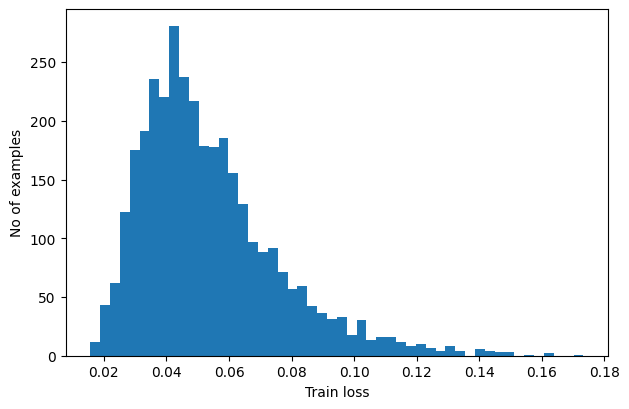

In [11]:
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [12]:

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.07599452497101894


16/16 [==============================] - 0s 1ms/step


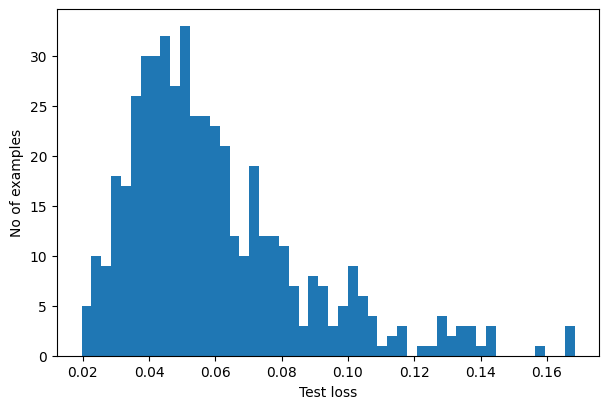

In [13]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [14]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

In [15]:
preds = predict(autoencoder, X_test, threshold)

In [17]:
anomalous_test_data = X_test[np.where(preds==False)]

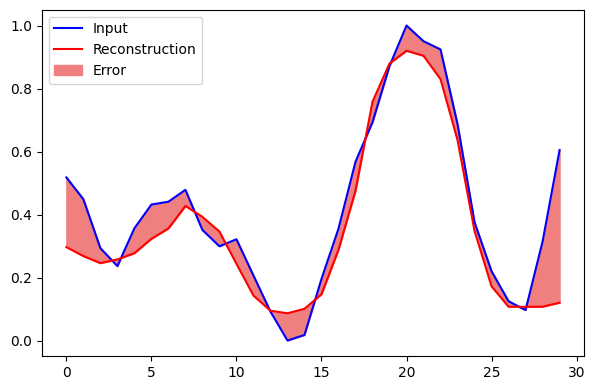

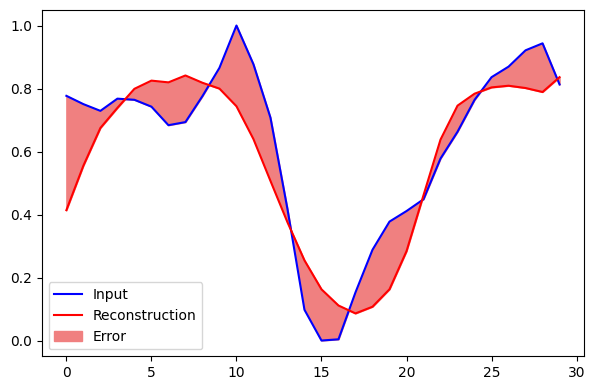

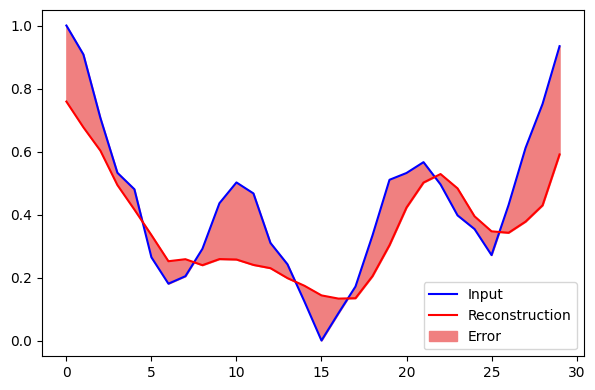

In [18]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()